In [304]:
# Load Biospytial modules and etc.
%matplotlib inline
import sys
sys.path.append('/apps')
import django
django.setup()
import pandas as pd
import matplotlib.pyplot as plt
## Use the ggplot style
plt.style.use('ggplot')

In [305]:
# My mac
#data = pd.read_csv("/RawDataCSV/plotsClimateData_11092017.csv")
# My Linux desktop
data = pd.read_csv("/RawDataCSV/idiv_share/plotsClimateData_11092017.csv")


In [186]:
data.SppN.mean()

5.1824128104220382

In [187]:
import geopandas as gpd

In [188]:
from django.contrib.gis import geos
from shapely.geometry import Point

In [189]:
data['geometry'] = data.apply(lambda z: Point(z.LON, z.LAT), axis=1)
new_data = gpd.GeoDataFrame(data)

## Let´s reproject to Alberts or something with distance

In [190]:
new_data.crs = {'init':'epsg:4326'}

### Uncomment to reproject
proj string taken from: http://spatialreference.org/

In [269]:
new_data =  new_data.to_crs("+proj=aea +lat_1=29.5 +lat_2=45.5 +lat_0=37.5 +lon_0=-96 +x_0=0 +y_0=0 +ellps=GRS80 +datum=NAD83 +units=m +no_defs ")

## The area is very big -> 35000 points. 
We need to make a subset of this


In [270]:
# COnsider the the following subregion
section = new_data[lambda x:  (x.LON > -90) & (x.LON < -85) & (x.LAT > 30) & (x.LAT < 35) ]

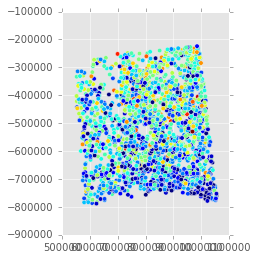

In [271]:
section.plot(column='SppN')

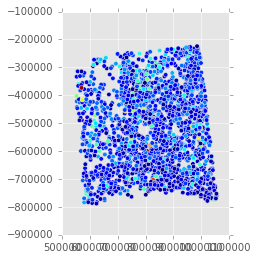

In [272]:
section.plot(column='plotBiomass')

In [273]:
section.shape

(1841, 42)

In [274]:
section['newLon'] = section.apply(lambda c : c.geometry.x, axis=1)
section['newLat'] = section.apply(lambda c : c.geometry.y, axis=1)

/opt/conda/envs/biospytial/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/opt/conda/envs/biospytial/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


# Model Fitting Using a GLM 

The general model will have the form:
$$ Biomass(x,y) = \beta_1 AET + \beta_2 Age + Z(x,y) + \epsilon $$
Where:
$\beta_1$ and $\beta_2$ are model parameters, $Z(x,y)$ is the *Spatial Autocorrelation* process and $\epsilon \sim N(0,\sigma^2)$

In [277]:
len(data.lon)
#X = data[['AET','StandAge','lon','lat']]
X = section[['SppN','lon','lat']]
X = section[['SppN','newLon','newLat']]
#X = data[['lon','lat']]
Y = section['plotBiomass']
#Y = data[['SppN']]
## First step in spatial autocorrelation
#Y = pd.DataFrame(np.zeros(len(Y)))
## Let´s take a small sample only for the spatial autocorrelation
import numpy as np
sample_size = 2000
randindx = np.random.randint(0,X.shape[0],sample_size)
nX = X.loc[randindx]
nY = Y.loc[randindx]


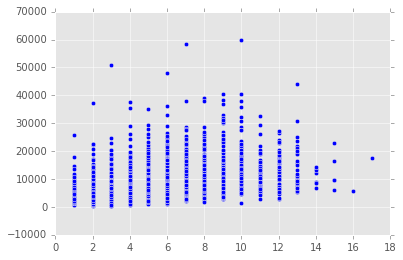

In [278]:
plt.scatter(X.SppN,Y)

In [279]:
## Let´s make a simple linear trend here.
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score


In [280]:
X.SppN.values.reshape(-1,1)

array([[12],
       [ 3],
       [15],
       ..., 
       [ 3],
       [ 8],
       [ 6]])

In [281]:

# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets (Only for the SppN)
#Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) 
regr.fit(X.SppN.values.reshape(-1,1), Y.values.reshape(-1,1))

# Make predictions using the testing sppN
spp_rich = np.linspace(0,100,100)

Y_hat = regr.predict(spp_rich.reshape(-1,1))

print(regr)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)


In [282]:
### Now with statsmodels.api

#xx = X.SppN.values.reshape(-1,1)
#xx = sm.add_constant(xx)
#model = sm.OLS(Y.values.reshape(-1,1),xx)

model = smf.ols(formula='plotBiomass ~ SppN',data=section)
results = model.fit()
param_model = results.params
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            plotBiomass   R-squared:                       0.098
Model:                            OLS   Adj. R-squared:                  0.097
Method:                 Least Squares   F-statistic:                     199.4
Date:                Tue, 17 Oct 2017   Prob (F-statistic):           4.58e-43
Time:                        15:52:08   Log-Likelihood:                -18728.
No. Observations:                1841   AIC:                         3.746e+04
Df Residuals:                    1839   BIC:                         3.747e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept   5903.2680    328.620     17.964      0.000      5258.761  6547.776
SppN         661.6803     46.856     14.121      0.000       569.783   753.578
==============================================================================
Omnibus:                      832.815   Durbin-Watson:                   2.007
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5484.680
Skew:                           2.019   Prob(JB):                         0.00
Kurtosis:                      10.430   Cond. No.                         15.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [303]:
## All data
### Now with statsmodels.api

#xx = X.SppN.values.reshape(-1,1)
#xx = sm.add_constant(xx)
#model = sm.OLS(Y.values.reshape(-1,1),xx)

model = smf.ols(formula='plotBiomass ~ SppN',data=data)
results = model.fit()
param_model = results.params
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            plotBiomass   R-squared:                       0.059
Model:                            OLS   Adj. R-squared:                  0.059
Method:                 Least Squares   F-statistic:                     2327.
Date:                Wed, 18 Oct 2017   Prob (F-statistic):               0.00
Time:                        17:12:55   Log-Likelihood:            -3.7722e+05
No. Observations:               36845   AIC:                         7.544e+05
Df Residuals:                   36843   BIC:                         7.545e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept   7251.3071     75.053     96.616      0.000      7104.201  7398.413
SppN         616.9022     12.788     48.240      0.000       591.837   641.967
==============================================================================
Omnibus:                    17776.531   Durbin-Watson:                   1.702
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           155578.928
Skew:                           2.139   Prob(JB):                         0.00
Kurtosis:                      12.113   Cond. No.                         12.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Residuals

In [283]:
Y_hat = results.predict(section)

In [284]:
ress = (section.plotBiomass - Y_hat)

In [285]:
## They are eq. test this ress - results.resid

In [286]:
param_model.Intercept

5903.2680378095029

,0,1
Intercept,5258.760549,6547.775527
SppN,569.782833,753.577725


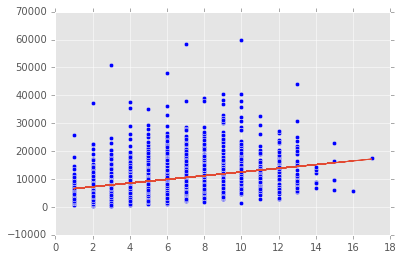

In [287]:
conf_int = results.conf_int(alpha=0.05)
plt.scatter(section.SppN,section.plotBiomass)
#plt.plot(section.SppN,param_model.Intercept + param_model.SppN * section.SppN)

plt.plot(section.SppN,Y_hat)
#plt.fill_between(Y_hat,Y_hat + conf_int , Y_hat - conf_int)
conf_int

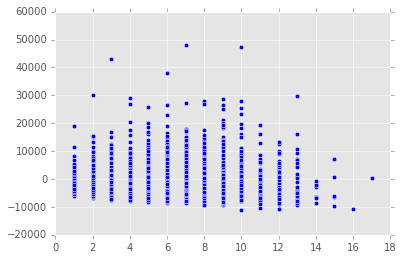

In [288]:
plt.scatter(section.SppN,results.resid)

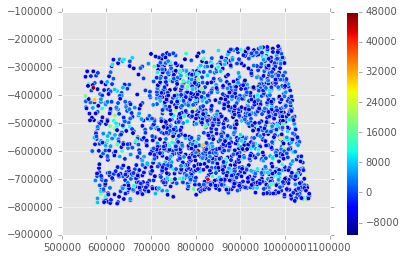

In [290]:
plt.scatter(section.newLon,section.newLat,c=results.resid)
plt.colorbar()

In [291]:
# Import GPFlow
import GPflow as gf
k = gf.kernels.Matern12(2, lengthscales=0.2, active_dims = [0,1] )

In [292]:
k1 = gf.kernels.Constant

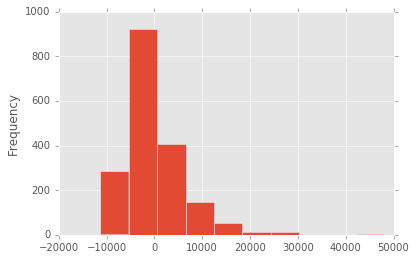

In [293]:
results.resid.plot.hist()

In [294]:
model = gf.gpr.GPR(section[['newLon','newLat']].as_matrix(),results.resid.values.reshape(-1,1),k)

In [295]:
%time model.optimize()

CPU times: user 4min 23s, sys: 13.1 s, total: 4min 36s
Wall time: 1min 40s


      fun: 18740.970248857207
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([ -0.00000000e+00,  -4.70897353e-06,  -4.70897824e-06])
  message: 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 61
      nit: 60
   status: 0
  success: True
        x: array([ -1.50777732e+00,   1.70852412e+07,   1.70852580e+07])

In [297]:
k.get_parameter_dict()

{'name.kern.lengthscales': array([ 0.2]),
 'name.kern.variance': array([ 17085241.212244])}

In [298]:
model.get_parameter_dict()

{'name.kern.lengthscales': array([ 0.2]),
 'name.kern.variance': array([ 17085241.212244]),
 'name.likelihood.variance': array([ 17085258.03398684])}

In [299]:
import numpy as np
Nn = 300
dsc = section
predicted_x = np.linspace(min(dsc.newLon),max(dsc.newLon),Nn)
predicted_y = np.linspace(min(dsc.newLat),max(dsc.newLat),Nn)
Xx, Yy = np.meshgrid(predicted_x,predicted_y)
## Fake richness
fake_sp_rich = np.ones(len(Xx.ravel()))
predicted_coordinates = np.vstack([ Xx.ravel(), Yy.ravel()]).transpose()
#predicted_coordinates = np.vstack([section.SppN, section.newLon,section.newLat]).transpose()

In [300]:
predicted_coordinates.shape

(90000, 2)

In [301]:
means,variances = model.predict_y(predicted_coordinates)

In [302]:
sum(means)

array([  4.13568672e-77])

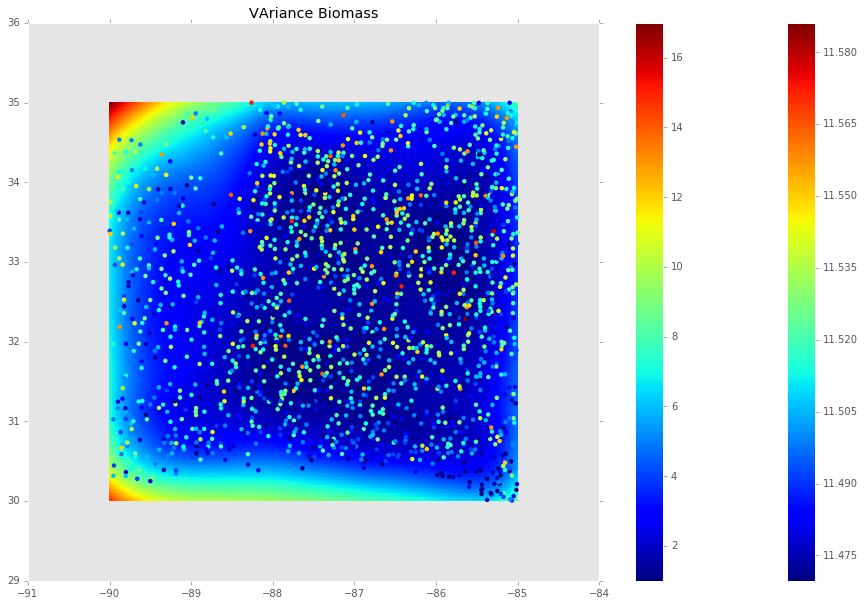

In [152]:
fig = plt.figure(figsize=(16,10), dpi= 80, facecolor='w', edgecolor='w')
#plt.pcolor(Xx,Yy,np.sqrt(variances.reshape(Nn,Nn))) #,cmap=plt.cm.Greens)
plt.pcolormesh(Xx,Yy,np.sqrt(variances.reshape(Nn,Nn)))
plt.colorbar()
plt.scatter(dsc.newLon,dsc.newLat,c=dsc.SppN,edgecolors='')
plt.title("VAriance Biomass")
plt.colorbar()

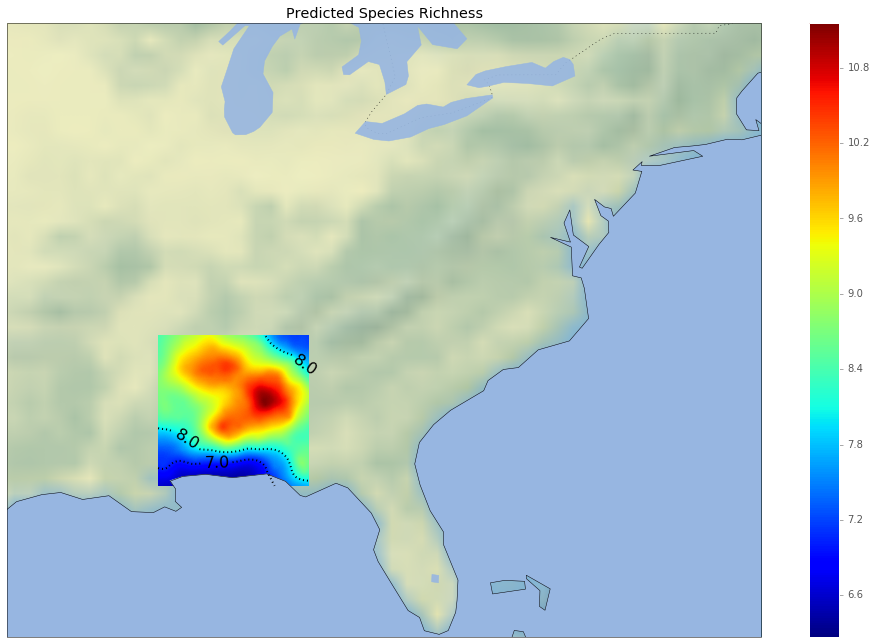

In [153]:
import cartopy
plt.figure(figsize=(17,11))

proj = cartopy.crs.PlateCarree()
ax = plt.subplot(111, projection=proj)


ax = plt.axes(projection=proj)
#algo = new_data.plot(column='SppN',ax=ax,cmap=colormap,edgecolors='')


#ax.set_extent([-93, -70, 30, 50])
#ax.set_extent([-100, -60, 20, 50])
ax.set_extent([-95, -70, 25, 45])

#ax.add_feature(cartopy.feature.LAND)
ax.add_feature(cartopy.feature.OCEAN)
ax.add_feature(cartopy.feature.COASTLINE)
ax.add_feature(cartopy.feature.BORDERS, linestyle=':')
ax.add_feature(cartopy.feature.LAKES, alpha=0.9)
ax.stock_img()
#ax.add_geometries(new_data.geometry,crs=cartopy.crs.PlateCarree())
#ax.add_feature(cartopy.feature.RIVERS)
mm = ax.pcolormesh(Xx,Yy,means.reshape(Nn,Nn),transform=proj )
#cs = plt.contour(Xx,Yy,np.sqrt(variances).reshape(Nn,Nn),linewidths=2,cmap=plt.cm.Greys_r,linestyles='dotted')
cs = plt.contour(Xx,Yy,means.reshape(Nn,Nn),linewidths=2,colors='k',linestyles='dotted',levels=[4.0,5.0,6.0,7.0,8.0])
plt.clabel(cs, fontsize=16,inline=True,fmt='%1.1f')
#ax.scatter(new_data.lon,new_data.lat,c=new_data.error,edgecolors='',transform=proj,cmap=plt.cm.Greys,alpha=0.2)
plt.colorbar(mm)
plt.title("Predicted Species Richness")


#(x.LON > -90) & (x.LON < -80) & (x.LAT > 40) & (x.LAT < 50)

## Residuals of $ Biomass ~ SppRich + Z(x,y) + \epsilon $
Using all data



## Model Analysis


In [154]:
model.kern

Name,values,prior,constraint
kern.lengthscales,[ 30.78216825],None,+ve
kern.variance,[ 49.04668716],None,+ve


In [155]:
model.likelihood

Name,values,prior,constraint
likelihood.variance,[ 130.6060247],None,+ve


## Let's calculate the residuals

In [156]:
X_ = section[['LON','LAT']]
%time resid_hat, resid_hat_variance = model.predict_y(X_)

CPU times: user 1.22 s, sys: 140 ms, total: 1.36 s
Wall time: 1.25 s


In [158]:
resid_hat.shape

(1841, 1)

In [159]:
qr_errors = qr_errors.values.reshape(len(qr_errors),1)

In [160]:
#new_data= new_data.assign(error=lambda y : (y.SppN - y.pred_y)**2 )
sqr_error_errors = pd.DataFrame((qr_errors - resid_hat)**2)

In [161]:
print(sqr_error_errors[0].mean())
print(sqr_error_errors[0].std())

129.423882449
449.938616815


In [183]:
true_error

0    [[27.3755518619, 201.52751954, 5.29125409885, ...
dtype: object

In [162]:
sqr_error_errors.mean()

0    129.423882
dtype: float64

In [130]:
k.ARD?